#Classification of Wafer maps patterns

In [ ]:
!pip install gdown

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from random import randint
import gdown


In [3]:
random_state = 42

In [4]:
df_names = ['Lot', 'Wafer', 'X', 'Y', 'Ring', 'Spot', 'Trend', 'Twospots', 'Crescent']
df_patterns = ['Ring', 'Spot', 'Trend', 'Twospots', 'Crescent']

In [5]:
url='https://drive.google.com/drive/folders/10ub0mO9X9JWUpNBnn_KG9MYpooEV_EA6'
output = 'dataset'
gdown.download_folder(url,quiet=False)
df_train = pd.read_csv('wafer_dataset/training_1.csv', sep = ';', names = df_names, skiprows = 1, usecols =list(range(9)))
df_test = pd.read_csv('wafer_dataset/test.csv', sep = ';', names = df_names, skiprows = 1, usecols =list(range(9)))

Retrieving folder list


Processing file 1F1R6OTb_ovg-gIsOmz6fdmD-ZJeGAEy8 test.csv
Processing file 10MU5Vn0rFkpgyk3QBpZo1vl_Gdhmdpty training_1.csv
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1F1R6OTb_ovg-gIsOmz6fdmD-ZJeGAEy8
To: /Users/andreamatteazzi/Downloads/classification_wafer_maps/wafer_dataset/test.csv
100%|██████████| 758M/758M [01:28<00:00, 8.57MB/s] 
Downloading...
From: https://drive.google.com/uc?id=10MU5Vn0rFkpgyk3QBpZo1vl_Gdhmdpty
To: /Users/andreamatteazzi/Downloads/classification_wafer_maps/wafer_dataset/training_1.csv
100%|██████████| 757M/757M [01:30<00:00, 8.33MB/s] 
Download completed


##DATA EXPLORATION

In [6]:
df_train[df_patterns].replace({',': '.'}, regex=True).astype(float).describe()

,Ring,Spot,Trend,Twospots,Crescent
count,3.501800e+06,3.501800e+06,3.501800e+06,3.501800e+06,3.501800e+06
mean,5.732177e-03,2.654154e-04,9.212136e-01,4.547181e-03,5.233860e-02
std,1.214828e-02,7.226065e-04,7.625365e-01,7.132302e-03,1.037377e-01
min,-1.371380e-02,-6.828007e-04,-1.064043e+00,-3.780359e-03,-6.932183e-02
25%,-1.121898e-04,-2.629139e-05,3.702197e-01,1.875964e-04,-1.748509e-03
50%,7.945610e-04,3.792103e-05,8.440702e-01,1.112328e-03,7.391925e-03
75%,6.387053e-03,1.671109e-04,1.484407e+00,6.139415e-03,5.419633e-02
max,1.093425e-01,8.460698e-03,3.124717e+00,4.673119e-02,9.030872e-01


The dataset is composed by instances whereas for the same 'Wafer' value, there are all the coordinates of the corresponding wafermap 'X', 'Y' and the corresponding values for each of the pattern.
From this dataset, it is important to generate the corresponding Wafer map images: for each Wafer an image for each pattern.  

In [7]:
max_dim = np.array(df_train[['X', 'Y']]).max(axis=0)
size_X = max_dim[0] 
size_Y = max_dim[1] 
size = max(size_X, size_Y) + max(size_X, size_Y)%2

In [8]:
def array_to_img(arr, size=size):
    img = np.zeros((size, size)).astype(float)
    for i in range(arr.shape[0]):
        img[arr[i, 0] - 1, arr[i, 1] - 1] = float(arr[i, 2].replace(',', '.'))
    return img

In [9]:
def df_to_dataset(df, all=False, num_wafmap = 0):
  wafers = df['Wafer'].unique()
  wafers = shuffle(wafers, random_state=random_state)
 
  if all:
    num_wafmap = wafers.shape[0]
  
  X = np.zeros((num_wafmap, size, size, len(df_patterns))).astype(float)
  
  for i in range(0, num_wafmap):
    wafer = df.loc[df['Wafer']==wafers[i]]
    for p in range(len(df_patterns)):
        X[i, :, :, p] = array_to_img(np.array(wafer[['X', 'Y', df_patterns[p]]]))
 
  X = np.concatenate([X[:,:,:,p] for p in range(len(df_patterns))], axis=0)
  X = X[:, :, :, np.newaxis] 
 
  y = np.zeros((len(df_patterns)*num_wafmap, len(df_patterns)))
  
  for p in range(len(df_patterns)):
    y[p*num_wafmap: p*num_wafmap + num_wafmap, p] = 1    
  
  return X, y

In [10]:
num_wafmap = 20
 
X, y = df_to_dataset(df_train, num_wafmap=num_wafmap)
 
X_test, y_test = df_to_dataset(df_test, all=True)

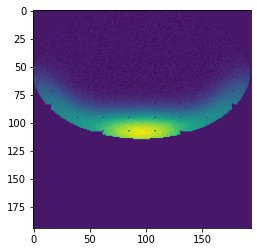

In [11]:
i = randint(0, 99) #between 0 and 99
 
plt.imshow(X[i,:,:,0])
plt.show()

##DATA AUGMENTATION

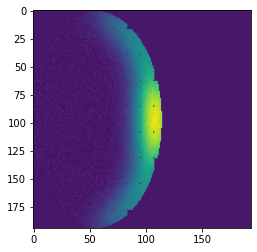

In [12]:
X_rot = np.rot90(np.copy(X), axes=(1,2))
 
plt.imshow(X_rot[i,:,:,0])
plt.show()

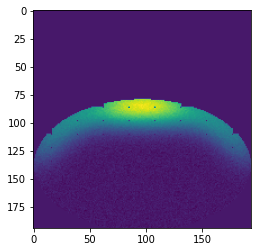

In [13]:
X_flip = np.rot90(np.copy(X_rot), axes=(1,2))
 
plt.imshow(X_flip[i,:,:,0])
plt.show()

The simplest augmentation procedure for images is obtained through rotations.
A more advanced data augmentation technique is obtained by autoencoders. An autoencoder is trained on the images and then new images are obtained by the original ones by perturbing the encoding of the original images with some noise. 

In [14]:
X = np.concatenate((X, X_rot, X_flip), axis = 0)
y = np.concatenate((y, y, y), axis=0)

X, y = shuffle(X, y, random_state=random_state) 
X_test, y_test = shuffle(X_test, y_test, random_state=random_state)

In [15]:
input_tensor = keras.Input(X.shape[1:])
encode = keras.layers.Conv2D(64, (3,3), padding='same', activation='tanh')(input_tensor)
 
latent_vector = encode = keras.layers.MaxPool2D()(encode)
 
 
decode_layer_1 = keras.layers.Conv2DTranspose(64, (3,3), padding='same', activation='tanh')
decode_layer_2 = keras.layers.UpSampling2D()
 
output_img = keras.layers.Conv2DTranspose(1, (3,3), padding='same', activation='tanh')
 
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)
 
 
 
autoencoder = keras.models.Model(input_tensor, output_img(decode))
 
autoencoder.compile(optimizer = 'Adam', loss = 'mse')
 
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 194, 194, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 194, 194, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 97, 97, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 97, 97, 64)       36928     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 194, 194, 64)     0         
 )                                                               
                                                             

In [16]:
autoencoder.fit(X, X, epochs=10, batch_size=32, shuffle=True)

Epoch 1/10
10/10 [==============================] - 13s 1s/step - loss: 0.0489
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 0.0432
Epoch 3/10
10/10 [==============================] - 12s 1s/step - loss: 0.0355
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 0.0343
Epoch 5/10
10/10 [==============================] - 11s 1s/step - loss: 0.0331
Epoch 6/10
10/10 [==============================] - 11s 1s/step - loss: 0.0327
Epoch 7/10
10/10 [==============================] - 11s 1s/step - loss: 0.0325
Epoch 8/10
10/10 [==============================] - 11s 1s/step - loss: 0.0323
Epoch 9/10
10/10 [==============================] - 11s 1s/step - loss: 0.0320
Epoch 10/10
10/10 [==============================] - 11s 1s/step - loss: 0.0318


In [17]:
encoder = keras.models.Model(input_tensor, latent_vector)
 
decoder_input = keras.Input((int(size/2), int(size/2), 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)
 
decoder = keras.models.Model(decoder_input, output_img(decode))
 
encoded_x = encoder.predict(X)
 
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=1e-7, size = encoded_x.shape)
 
X_dcae = decoder.predict(noised_encoded_x)

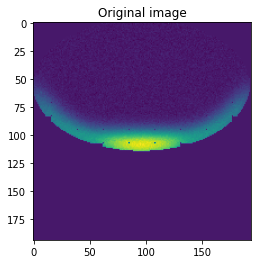

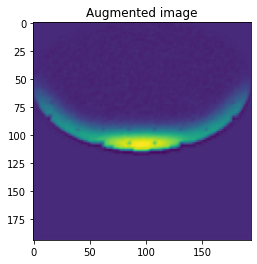

In [41]:
i = randint(0, 299)
plt.title('Original image')
plt.imshow(X[i,:,:,0])
plt.show()
plt.title('Augmented image')
plt.imshow(X_dcae[i,:,:,0])
plt.show()

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=random_state)

##MODEL DESIGN AND TRAINING

In [20]:
model = keras.models.Sequential([keras.layers.Conv2D(filters=8, kernel_size=[3,3], padding="same", activation="relu", input_shape=X_train.shape[1:]), 
                                 keras.layers.MaxPool2D(),keras.layers.Conv2D(filters=16, kernel_size=[3,3], padding="same", activation="relu"), 
                                 keras.layers.Flatten(), keras.layers.Dense(5, activation="softmax") ])
 
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
 
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 194, 194, 8)       80        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 97, 97, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 97, 97, 16)        1168      
                                                                 
 flatten (Flatten)           (None, 150544)            0         
                                                                 
 dense (Dense)               (None, 5)                 752725    
                                                                 
Total params: 753,973
Trainable params: 753,973
Non-trainable params: 0
__________________________________________________

In [21]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.legend(['loss', 'val_loss'])
  plt.title('accuracy')

Epoch 1/10
7/7 [==============================] - 2s 169ms/step - loss: 1.3123 - accuracy: 0.3048 - val_loss: 1.0339 - val_accuracy: 0.7222
Epoch 2/10
7/7 [==============================] - 1s 130ms/step - loss: 0.8853 - accuracy: 0.6762 - val_loss: 0.6159 - val_accuracy: 0.6222
Epoch 3/10
7/7 [==============================] - 1s 136ms/step - loss: 0.6357 - accuracy: 0.7905 - val_loss: 0.4872 - val_accuracy: 1.0000
Epoch 4/10
7/7 [==============================] - 1s 146ms/step - loss: 0.5005 - accuracy: 0.9762 - val_loss: 0.3367 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 1s 149ms/step - loss: 0.3439 - accuracy: 0.9905 - val_loss: 0.2115 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 1s 155ms/step - loss: 0.2062 - accuracy: 0.9905 - val_loss: 0.1103 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 1s 160ms/step - loss: 0.1191 - accuracy: 0.9952 - val_loss: 0.1460 - val_accuracy: 1.0000
Epoch 8/10
7/7 [====

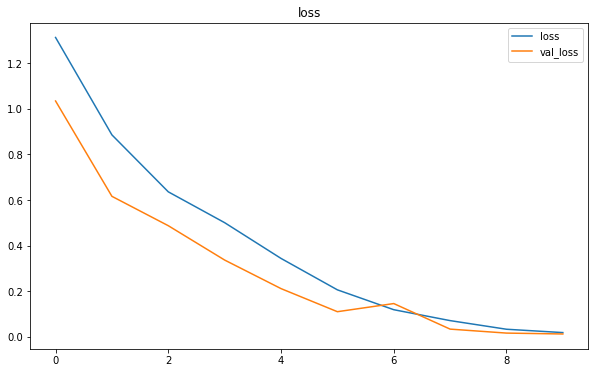

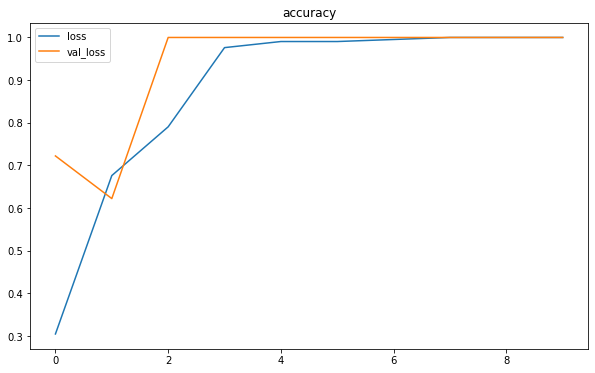

In [22]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), shuffle=True)
plot_loss(history)
plot_accuracy(history)

In [23]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

32/32 [==============================] - 2s 47ms/step - loss: 0.0142 - accuracy: 1.0000
test loss, test acc: [0.014166604727506638, 1.0]


##EVALUATION

In [24]:
pred = model.predict(X_test)

In [25]:
print('F1 score for each pattern type vs all others: ', f1_score(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), average=None))

F1 score for each pattern type vs all others:  [1. 1. 1. 1. 1.]


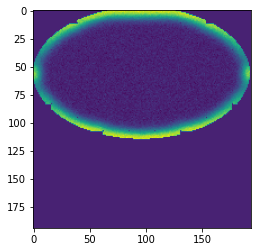

Pattern Type: Ring
Model prediction: Ring


In [34]:
p = randint(0, 999) #between 0 and 999

plt.imshow(X_test[p,:,:,0])
plt.show()
print('Pattern Type:', df_patterns[np.argmax(y_test[p])])
print('Model prediction:', df_patterns[np.argmax(pred[p:p+1])])